# Logistic Regression
We will begin with the binary classification problem, which can then be trivially generalized to multi-class problems using OneVsOne or OneVsAll
## 1. Notations
$\DeclareMathOperator{\argmin} {arg min}
\DeclareMathOperator{\argmax} {arg max}$
- Let $E=\mathbb{R}^m$ the vector space a features
- Let $P=\mathbb{R}^{m+1}$ be a vector space in which the parameters vary
- For $\omega \in P$, we will denote $w_*=(w_1,..w_n)$
- We will denote by $\mathbb{1}_i \in \mathbb{R}^i $ the vector of ones $\forall i \in \mathbb{N}$ 
- Let $F\in \mathscr{C}^1$ a cumulative probability function
- Let $m\in\mathbb{N}^*$ the number of features.
- Let $n \in \mathbb{N}^*$ the number of samples
- Let $X \in E^n$ be a tuple of input samples 
- Let $Y \in \{0,1\}^n$ be a tuple of samples 
- Let $C \in \mathbb{R}_+$ be a hyperparameter
- Let $\mathscr{N}=\lVert\cdot\rVert$ be a norm on $E$
- Let $\mathscr{l}\in \mathscr{F}\left([0,1]^2,\mathbb{R}\right)$ the unit cost function
- Let $\mathscr{L} \in \mathscr{F}\left(P,\mathbb{R}\right)/$
$$\forall \omega \in P,\quad \mathscr{L}(\omega)=C\sum_{i=1}^{n}\mathscr{l}\left(F(X_i^T\omega_*+\omega_0),Y_i\right)+\lVert \omega_*\rVert$$
## 2. Objective
We will try to find: $$\omega_m=\arg\min_{\omega\in P} \mathscr{L}(\omega)$$

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
def createIRIS():
    data=datasets.load_iris()
    U=pd.DataFrame(data["data"],columns=data["feature_names"])
    labels=pd.Series(data["target_names"])
    U["target"]=data["target"]
    U["label"]= [labels[i] for i in data["target"]]
    return U
U = createIRIS()
U.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,label
133,6.3,2.8,5.1,1.5,2,virginica
108,6.7,2.5,5.8,1.8,2,virginica
118,7.7,2.6,6.9,2.3,2,virginica
79,5.7,2.6,3.5,1.0,1,versicolor
128,6.4,2.8,5.6,2.1,2,virginica


In [2]:
from sklearn.model_selection import train_test_split
X=U[U.columns[:-2]]
Y=U[U.columns[-2]]
X_train,X_test,Y_train,Y_test=train_test_split(X,Y)

In [3]:
from scipy import optimize
from scipy.special import xlogy
import scipy

def sigmoid(x):
    return 1/(1+np.exp(-x))

def dsig(x):
    S=sigmoid(x)
    return S*(1-S)

class BinaryLogisticRegression:
    def __init__(self,C=1,p=0.5,F=sigmoid,dF=None,N=np.linalg.norm,N_args=[]):
        self.C=C
        self.p=p
        self.F=F
        self.dF=dF
        self.cost=BinaryLogisticRegression.cost
        self.N_args=N_args
        self.N=lambda u:N(u,*self.N_args)
        self.cost=BinaryLogisticRegression.cost
    def predict(self,X):
        return self.decision_function(X)>self.p
    def decision_function(self,X):
        return self.F(X@self.w[1:]+self.w[0])
    def fit(self,X,Y):
        self.w=optimize.minimize(lambda w:self.cost(X,Y,w,self.F,self.C,self.N),jac=None,x0=np.zeros(X.shape[1]+1)).x
        return self
    def parameters(self):
        return self.w
    def score(self,X,Y):
        return (self.predict(X)==Y).mean()
    @classmethod
    def cost(cls,X,Y,w,F,C,N):
        H=F(X@w[1:]+w[0])        
        return -C*np.sum(xlogy(Y,H)+xlogy(1-Y,1-H))+N(w[1:])
    pass

class OneVsAllLogisticRegression:
    def __init__(self,C=1,F=sigmoid,dF=None,N=np.linalg.norm,N_args=[],cost=BinaryLogisticRegression.cost):
        self.C=C
        self.F=F
        self.dF=dF
        self.N=N
        self.cost=cost
    def fit(self,X,Y):
        X=np.array(X)
        Y=np.array(Y)
        self.k=np.max(Y)+1
        self.W=np.zeros([X.shape[1]+1,self.k])
        for i in range(self.k):
            self.W[:,i]=BinaryLogisticRegression(C=self.C,F=self.F,dF=self.dF,N=self.N,N_args=self.N_args,cost=self.cost).fit(X,Y==i).parameters()
        
    def predict(self,X):
        S=np.zeros([X.shape[0],self.k])
        V=self.F(np.array(X)@self.W[1:,:]+self.W[0,:])
        for s in range(X.shape[0]):
            for i in range(self.k):
                P=np.full(self.k,(1-V[s,i])/(self.k-1))
                P[i]=V[s,i]
                S[s,i]=S[s,i]+P[i]
        return np.argmax(S,axis=1)
    def parameters():
        return self.W
    pass
        
class OneVsOneLogisticRegression:
    def __init__(self,C=1,F=sigmoid,dF=None,N=np.linalg.norm,N_args=[],cost=BinaryLogisticRegression.cost):
        self.C=C
        self.F=F
        self.dF=dF
        self.N=N
        self.N_args=N_args
        self.cost=cost
    def fit(self,X,Y):
        X=np.array(X)
        Y=np.array(Y)
        self.k=np.max(Y)+1
        nCr=lambda a,b:int(scipy.special.comb(a,b))
        m=nCr(self.k,2)
        self.W=np.zeros([X.shape[1]+1,m])
        for i in range(self.k):
            for j in range(i):
                mask=(Y==i)|(Y==j)
                self.W[:,nCr(i,2)+j]=BinaryLogisticRegression(C=self.C,F=self.F,dF=self.dF,N=self.N,N_args=self.N_args,cost=self.cost).fit(X[mask],Y[mask]==j).parameters()
        
    def predict(self,X):
        nCr=lambda a,b:int(scipy.special.comb(a,b))
        m=nCr(self.k,2)
        S=np.zeros([X.shape[0],self.k])
        X=np.array(X)
        V=self.F(X@self.W[1:,:]+self.W[0,:])
        P=np.zeros(self.k)
        for s in range(X.shape[0]):
            for i in range(self.k):
                for j in range(i):                    
                    S[s,j]=S[s,j]+V[s,nCr(i,2)+j]
                    S[s,i]=S[s,i]+1-V[s,nCr(i,2)+j]
        return np.argmax(S,axis=1)
    def parameters():
        return self.W
    pass

class MultinomialLogisticRegression:
    def __init__(self,C=1,F=sigmoid,dF=None,N=np.linalg.norm,N_args=[],cost=BinaryLogisticRegression.cost):
        self.C=C
        self.F=F
        self.dF=dF
        self.N=N
        self.cost=cost
    def fit(self,X,Y):
        X=np.array(X)
        Y=np.array(Y)
        self.k=np.max(Y)+1
        self.W=np.zeros([X.shape[1]+1,self.k])
        for i in range(self.k):
            self.W[:,i]=BinaryLogisticRegression(C=self.C,F=self.F,dF=self.dF,N=self.N).fit(X,Y==i).parameters()
        
    def predict(self,X):
        S=np.zeros([X.shape[0],self.k])
        V=self.F(np.array(X)@self.W[1:,:]+self.W[0,:])
        
        return np.argmax(V,axis=1)
    def decision_function(self,X):
        S=np.zeros([X.shape[0],self.k])
        V=self.F(np.array(X)@self.W[1:,:]+self.W[0,:])
        max_index=np.argmax(V,axis=1)
        T=np.array([V[i,max_index[i]] for i in range(max_index.shape[0])])
        return  max_index + T
    def parameters():
        return self.W
    pass

In [4]:
def S0(x):
    if(x<=0):
        return 0
    return np.exp(-1/x**2)
classifier=MultinomialLogisticRegression(C=10,N=lambda u:np.linalg.norm(u,ord=2),cost=lambda X,Y,w,F,C,N:
                                      C*np.linalg.norm(F(X@w[1:]+w[0])-Y)+N(w[1:]))
classifier.fit(X_train,Y_train)

In [5]:
print((classifier.predict(X_test)==Y_test).mean())

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

0.9736842105263158


In [7]:
LogisticRegression(C=1000,max_iter=1000).fit(X_train,Y_train).score(X_test,Y_test)

0.9210526315789473

In [8]:
SVC(kernel="poly",degree=2).fit(X_train,Y_train).score(X_test,Y_test)

0.9736842105263158

(150, 150)


<ipython-input-9-bc4e9f00bd2b>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(U_mesh[:,:,0], U_mesh[:,:,1], np.tanh(.225*Y_mesh),alpha=.65)


Text(0.5, 1.0, 'Lineary separable data')

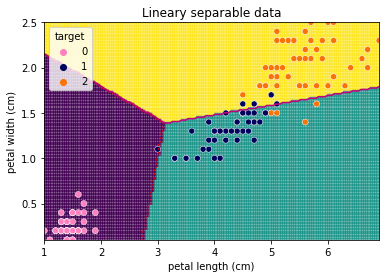

In [9]:
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
model=MultinomialLogisticRegression()
U=X[X.columns[2:4]]
model.fit(U,Y)
m=LinearSVC().fit(U,Y)
fig,ax=plt.subplots()
x=np.linspace(np.min(U[U.columns[0]]),np.max(U[U.columns[0]]),150)
y=np.linspace(np.min(U[U.columns[1]]),np.max(U[U.columns[1]]),150)
U_mesh=np.array(np.meshgrid(x,y)).transpose(1,2,0)
Y_mesh=m.predict(U_mesh.reshape((-1,2))).reshape((U_mesh.shape[0],U_mesh.shape[1]))
print(Y_mesh.shape)

c = ax.pcolormesh(U_mesh[:,:,0], U_mesh[:,:,1], np.tanh(.225*Y_mesh),alpha=.65)
c = ax.contour(U_mesh[:,:,0], U_mesh[:,:,1], Y_mesh, levels=[0,1,2],
               colors=["xkcd:red","xkcd:magenta","xkcd:blue"],linestyles=["dotted","solid","dotted"])
sns.scatterplot(x=U[U.columns[0]], y=U[U.columns[1]], hue=Y,ax=ax,palette=["xkcd:pink","xkcd:dark blue","xkcd:orange"]);
ax.set_title("Lineary separable data")


In [ ]:
sklearn.sv